In [1]:
DATA_PATH = "./data/"
OUTPUT_PATH = "./out/"

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lmfit
from lmfit import minimize, Parameters
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeavePOut

colorDic = {"blue" : "#6599FF", "yellow" : "#FFAD33",  "purple": "#683b96", "green" : "#198D6D", "red" : "#FF523F"}
colors = list(colorDic.values())

In [3]:
dfAcc= pd.read_pickle(DATA_PATH  + "data_01_acc.pkl")

In [4]:
dfStim = pd.read_pickle(DATA_PATH  + "data_03_stim.pkl")

In [5]:
minval = -200
maxval = 6000
binwidthSMALL = 50
binwidth = 50

In [6]:
def fit (X, Error, noCI = False):
    params = lmfit.Parameters()
    for i in range(11):
        params.add('x%i'%i, value=0)
    
    minfit = lmfit.Minimizer(residual, params, fcn_args=(X, Error))
    # first solve with Nelder-Mead
    out1 = minfit.minimize(method='Nelder')

    # then solve with Levenberg-Marquardt using the
    # Nelder-Mead solution as a starting point
    out2 = minfit.minimize(method='leastsq',  params=out1.params)

    if (noCI == False):
        ci, trace = lmfit.conf_interval(minfit, out2, sigmas=[2],
                                        trace=True, verbose=False)
        lst = []
        for name, row in ci.items():
            for cval, val in row:
                if (ci["a"][0][0] == cval):
                    lst.append([name, val])
        lst

        dfCoff = pd.DataFrame(lst, columns=["Coff", "Val"])
        dfCoff = dfCoff.groupby("Coff").agg({"Val": [np.min, np.max]})
        dfCoff.columns = ["Min", "Max"]
        dfCoff =dfCoff.reset_index()
        dfX = pd.DataFrame.from_dict(out2.params.valuesdict(), orient="index")
        dfX = dfX.reset_index()
        dfX.columns =["Coff", "Val"]
        dfCoff = pd.merge(dfCoff, dfX, on="Coff")
        return out2, dfCoff
    else:
        return out2

In [7]:
def fun(params, x):
    x0 = np.zeros(len(params))
    for i in range(len(params)):
        x0[i] = params["x"+str(i)]
    s = int(np.sqrt(len(params)))
    return np.polynomial.polynomial.polyval(x, x0)

def residual(params, x, z):
    x0 = np.zeros(len(params))
    for i in range(len(params)):
        x0[i] = params["x"+str(i)]
    s = int(np.sqrt(len(params)))
    return np.polynomial.polynomial.polyval(x, x0) - y

In [8]:
TouchEventId = dfStim.groupby(["TouchId"])["TouchEventId"].max().values

Speed 10
    R²                 = 0.460993
Speed 20
    R²                 = 0.449793
Speed 30
    R²                 = 0.792288
Speed 40
    R²                 = 0.742326
Speed 50
    R²                 = 0.846673


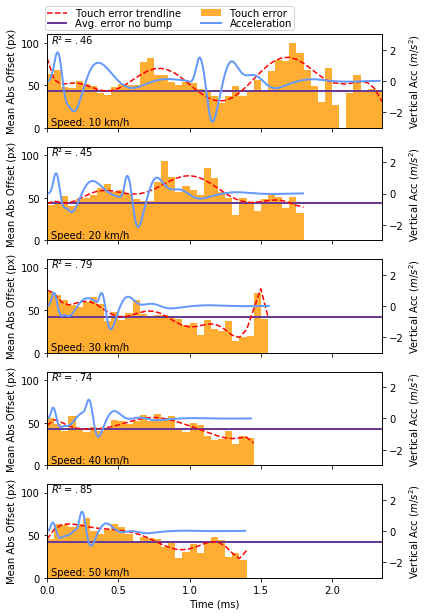

In [9]:
fig, axarr = plt.subplots(5, 1, sharex=True, figsize=(6,10))
plt.xlabel("Time (ms)")

meanNoBump = dfStim[(dfStim.IsBumpVirtual == 0) & dfStim.TouchEventId.isin(TouchEventId) & (dfStim.TouchType == 2)].groupby("SpeedCondition").mean().TouchOffset

for i in range(5):
    s = ((i+1) *10)
    ax = axarr[i]
    #fig, ax = plt.subplots(figsize=(6,2))
    #ax.set_title()
    ax.annotate("Speed: %i km/h" % (10*(i+1)) ,(30,3))
    df2 = dfStim[(dfStim.SpeedCondition == s) & (dfStim.TouchEventId.isin(TouchEventId)) & (dfStim.IsBumpVirtual == 1.0) & (dfStim.TouchType == 2)]
    #print(df2.TouchOffset.describe())
    df3 = df2.groupby("Bin").mean()
    r = (minval,maxval)
    plt.bar
    l1 = ax.bar((df3.index*binwidth)+r[0]-(binwidth/2.0), df3.TouchOffset, width=binwidth, color=colorDic["yellow"], label='Touch error')
    
    df2 = df2.copy()
    df2["TimeBin"] = np.round((df2.TimeRelativ/50).astype(float))*50
    df3 = df2.sort_values("TimeRelativ").groupby("TimeBin").mean().TouchOffset
    x = df3.index
    y = df3.values
    out1 = fit(x,y, noCI=True)
    print("Speed %i" % (s))
    rsquared = sklearn.metrics.r2_score(y, fun(out1.params, x))
    print ("    R²                 = %.6f" % rsquared)
    ax.plot(x, fun(out1.params, x),"r--", label="Touch error trendline")
    rs = ("$R²= %.2f$" % (rsquared)).replace("0.", ".")
    ax.annotate(rs,(30,100))
    
    ax.hlines(meanNoBump[int((i+1)*10)], 0, 2500, color=colorDic["purple"], lw=2, label="Avg. error no bump")

    ax2 = ax.twinx()
    df = dfAcc[dfAcc.Speed == s]
    l2=ax2.plot(df.Time, (df.Acc), label="Acceleration", c=colorDic["blue"], lw=2)
    
    ax.set_ylabel("Mean Abs Offset (px)")
    ax2.set_ylabel("Vertical Acc ($m/s^2$)")
    
    ax.set_ylim((0,110))    
    ax2.set_ylim(-3,3)
    
    if (i== 0):
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, ncol=2, loc=2, borderpad = 0.2, labelspacing = 0, bbox_to_anchor=(-.02, 1.25, 1., .10)) 

plt.xlim((0,2350))
ax.set_xticklabels(ax.get_xticks() /1000)
plt.savefig(OUTPUT_PATH + "offset.pdf", bbox_inches='tight',transparent=False, pad_inches=0)
plt.show()

In [10]:
minval = -200
maxval = 6000
binwidthSMALL = 50
dfStim["BinSmall"] = np.digitize(dfStim.TimeRelativ, list(range (minval,maxval,binwidthSMALL)))

Speed 10
    R²                 = 0.230069
Speed 20
    R²                 = 0.474470
Speed 30
    R²                 = 0.623635
Speed 40
    R²                 = 0.481702
Speed 50
    R²                 = 0.765253


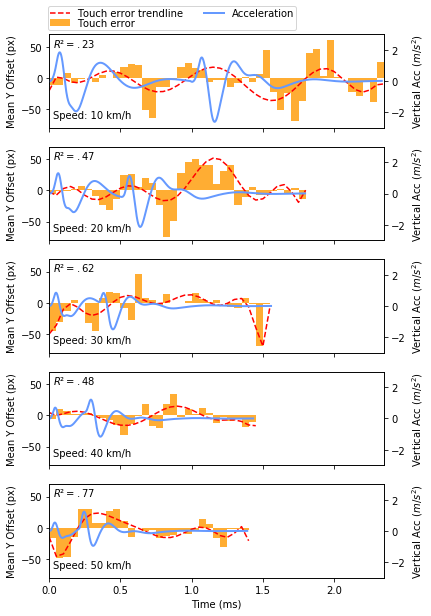

In [11]:
fig, axarr = plt.subplots(5, 1, sharex=True, figsize=(6,10))
plt.xlabel("Time (ms)")

meanNoBump = dfStim[(dfStim.IsBumpVirtual == 0) & dfStim.TouchEventId.isin(TouchEventId) & (dfStim.TouchType == 2)].groupby("SpeedCondition").mean().TouchOffsetY

for i in range(5):
    s = ((i+1) *10)
    ax = axarr[i]
    ax.annotate("Speed: %i km/h" % (10*(i+1)) ,(30,-65))
    df2 = dfStim[(dfStim.SpeedCondition == s) & (dfStim.TouchEventId.isin(TouchEventId)) & (dfStim.IsBumpVirtual == 1.0) & (dfStim.TouchType == 2)]

    df3 = df2.groupby("BinSmall").mean()
    r = (minval,maxval)
    plt.bar
    l1 = ax.bar((df3.index*binwidthSMALL)+r[0]-(binwidthSMALL/2.0), df3.TouchOffsetY, width=binwidthSMALL, color=colorDic["yellow"], label='Touch error')
    
    df2 = df2.copy()
    df2["TimeBin"] = np.round((df2.TimeRelativ/50).astype(float))*50
    df3 = df2.groupby("TimeBin").mean().TouchOffsetY
    x = df3.index
    y = df3.values
    out1 = fit(x,y, noCI=True)
    print("Speed %i" % (s))
    rsquared = sklearn.metrics.r2_score(y, fun(out1.params, x))
    print ("    R²                 = %.6f" % rsquared)
    ax.plot(x, fun(out1.params, x),"r--", label="Touch error trendline")
    rs = ("$R²= %.2f$" % (rsquared)).replace("0.", ".")
    ax.annotate(rs,(30,50))

    ax2 = ax.twinx()
    df = dfAcc[dfAcc.Speed == s]
    l2=ax2.plot(df.Time, df.Acc, label="Acceleration", c=colorDic["blue"], lw=2)
    #l2=ax2.plot(df.Time, df.Jerk*20, label="Jerk", c=colorDic["green"], lw=2)
    
    ax.set_ylabel("Mean Y Offset (px)")
    ax2.set_ylabel("Vertical Acc ($m/s^2$)")
    
    ax.set_ylim((-80,70))    
    ax2.set_ylim(-3,3)
    
    if (i== 0):
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, ncol=2, loc=2, borderpad = 0.2, labelspacing = 0, bbox_to_anchor=(-.02, 1.25, 1., .10)) 

plt.xlim((0,2350))
ax.set_xticklabels(ax.get_xticks() /1000)
plt.savefig(OUTPUT_PATH + "offset_y.pdf", bbox_inches='tight',transparent=False, pad_inches=0)
plt.show()

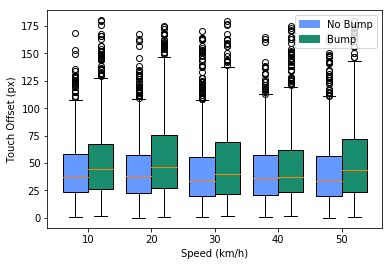

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
boxpropsNoCor = dict(linestyle='-', linewidth=3, color=colorDic["blue"])
boxpropsCor = dict(linestyle='-', linewidth=3, color=colorDic["green"])
width = 0.4
pos = np.array([1,2,3,4, 5])-(width/2)


List = []
noList = []
pos = 0
for Speed in sorted(dfStim.SpeedCondition.unique()):
    for IsBumpVirtual in [False, True]:
    
        dfX = dfStim[dfStim.TouchEventId.isin(TouchEventId) & (dfStim.IsBumpVirtual == IsBumpVirtual) & (dfStim.SpeedCondition == Speed)]

        
        if (IsBumpVirtual == False):
            x= plt.boxplot(dfX.TouchOffset, patch_artist=boxpropsNoCor, positions =[pos-(width/2)], widths=width, manage_xticks  = False)
            noList.append(x)
        else:
            x= plt.boxplot(dfX.TouchOffset, patch_artist=boxpropsCor, positions =[pos+(width/2)], widths=width, manage_xticks  = False)
            List.append(x)
    pos = pos +1

for i in noList:
    for box in i['boxes']:
        box.set(facecolor = colorDic["blue"])
    
for i in List:
    for box in i['boxes']:
        box.set(facecolor = colorDic["green"])
        
hG = mpatches.Patch(color=colorDic["blue"], label='No Bump')
hB = mpatches.Patch(color=colorDic["green"], label='Bump')
plt.legend(handles=[hG, hB], loc=1)

plt.xticks(range(0,5),[10,20,30,40,50])
plt.ylabel("Touch Offset (px)")
plt.xlabel("Speed (km/h)")
plt.savefig(OUTPUT_PATH + "offsets_mean.pdf" ,bbox_inches='tight',transparent=True, pad_inches=0)
plt.show()

In [13]:
dfStim[dfStim.TouchEventId.isin(TouchEventId)].groupby("IsBumpVirtual").TouchOffset.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
IsBumpVirtual,,,,,,,,
0.0,4574.0,42.59,28.90,0.00,21.23,35.69,56.77,170.50
1.0,4401.0,50.69,34.73,0.63,24.46,42.73,68.97,180.25
